# A quick demo for boundary context sample generation in our proposed FSVI method

This script provides examples of boundary samples in the 2D input space for the proposed function-space variational inference (FSVI) framework, which incorporates a contextual generative model.

⭐ Examples of boundary sample generation in realistic high-dimensional image input spaces can be found in (a) of the repository.

The motivation of this work is that: **_"boundary samples"_** can better facilitate FSVI (see Fig. 1). Based on this, we propose a boundaryGAN-BNN joint training framework (Section 3.4). It uses "boundary samples", generated by boundaryGAN, to improve the BNN's prediction accuracy, uncertainty calibration performance, and OOD detection ability (Section 4.2 ~ 4.5 ).

As shown in Fig. S4 (a), we now verify that the proposed approach (Algorithm S1) can indeed generate such expected "boundary samples" around the training data distribution.

This demo consists of two stages:
- **(a) Pre-training stage**: First, we solely use the standard FSVI method (Eq. (5)) to pre-train a Bayesian Neural Network (BNN) classifier with good classification capability, based on out-of-distribution (OOD) context samples obtained via rejection sampling.
- **(b) Joint-training stage**: Next, we use the proposed joint training algorithm to iteratively train the BNN classifier and the contextual generative model boundaryGAN. Then, we visualize the boundary samples generated by boundaryGAN and the decision boundary of the classifier.

In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
import os
from data_loader import rejection_sample_ood, get_two_gaussian
from models import fnn, Generator2d, Discriminator2d
import bayesianize.bnn as bnn
from helpers import seed_everything

In [2]:
# Plot training points generated by a mixture of Gaussians
def plot_train_loader(train_loader, size=100):
    all_data = []
    all_labels = []

    for batch_data, batch_labels in train_loader:
        all_data.append(batch_data)
        all_labels.append(batch_labels)
    data = torch.cat(all_data, dim=0).numpy()  # [N, 2]
    labels = torch.cat(all_labels, dim=0).numpy()  # [N]

    class0 = data[labels == 0]
    class1 = data[labels == 1]
    plt.scatter(class0[:, 0], class0[:, 1], marker='o', color='cornflowerblue', edgecolors='black', s=size, label='Class 0')
    plt.scatter(class1[:, 0], class1[:, 1], marker='o', color='tomato', edgecolors='black', s=size, label='Class 1')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()

# Plot OOD context samples obtained via rejection sampling
def plot_reject_ood_context_loader(ood_samples):
    ood_samples = ood_samples.detach().cpu().numpy()

    plt.scatter(ood_samples[:, 0], ood_samples[:, 1], marker='x', alpha=0.5, s=10, c='green', label='Context samples')

# Plot the generative boundary samples of boundaryGAN
def plot_generative_boundary_samples(fake):
    fake_np = fake.detach().cpu().numpy()
    plt.scatter(fake_np[:, 0], fake_np[:, 1], marker='*', color='darkgreen', edgecolors='springgreen', s=250, alpha=0.5)

    plt.xlim(-10, 10)
    plt.ylim(-10, 10)

    plt.tick_params(axis='both',
                    which='both',
                    bottom=False, top=False,
                    left=False, right=False,
                    labelbottom=False, labelleft=False)

# Plot the (blur/red) decision bound of BNN classifier
def plot_decision_bound(model, range=(-30, 30), cbar=False):
    x1 = np.linspace(*range, 100)
    x2 = np.linspace(*range, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    grid_data = np.c_[xx1.ravel(), xx2.ravel()]

    grid_tensor = torch.tensor(grid_data, dtype=torch.float32).to('cuda')
    with torch.no_grad():
        pred_probs = torch.nn.functional.softmax(model(grid_tensor), dim=1)[:, 1].cpu().numpy()

    plt.contourf(xx1, xx2, pred_probs.reshape(xx1.shape), alpha=1, levels=np.linspace(0, 1, 21), cmap='coolwarm', vmin=0, vmax=1)

    if cbar:
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=12)

    plt.xlim(*range)
    plt.ylim(*range)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

## (a) Pre-training Stage

Here, the BNN classifier is first pre-trained using the standard FSVI method (Eq. (5)) with out-of-distribution (OOD) context samples $\mathcal{C}$ obtained via rejection sampling in the interval $[-10, 10]^2$:

$$
\overline{\mathcal{F}}(q(\boldsymbol{\theta}))=\underbrace{\mathbb{E}_{q(\boldsymbol{\theta})}[\log p(\mathcal{T} \mid \boldsymbol{\theta})]}_{\text {Expected log-likelihood }}-\underbrace{\operatorname{KL}(q(\boldsymbol{\theta}) \| p(\boldsymbol{\theta}))}_{\text {Parameter-space regularization }}-\underbrace{\mathbb{E}_{q(\boldsymbol{\theta})}[\operatorname{cost}(\mathcal{C}, \boldsymbol{\theta})]}_{\text {Function-space regularization }}
$$

The function-space cost function is our newly proposed KL divergence cost defined in Eq. (4):

$$
\operatorname{cost}(\mathcal{C}, \boldsymbol{\theta})=\beta \sum_{m=1}^M \operatorname{KL}\left(f\left(\hat{\mathbf{x}}_m ; \boldsymbol{\theta}\right) \| \mathcal{U}\right), \text { where } \operatorname{KL}\left(f\left(\hat{\mathbf{x}}_m ; \boldsymbol{\theta}\right) \| \mathcal{U}\right)=\sum_{k=1}^K f\left(\hat{\mathbf{x}}_m ; \boldsymbol{\theta}\right)_k \log \frac{f\left(\widehat{\mathbf{x}}_m ; \boldsymbol{\theta}\right)_k}{\mathcal{U}_k}
$$

In [3]:
seed_everything(111)

 # Hyperparameters
batch_size = 25
nz = 100
lr =0.002
wd =0.0
decreasing_lr = 60
num_classes = 2
pre_beta, beta = 1, 5
log_interval = 100
pretrain_epochs, epochs = 100, 1000
drop_rate = 0.1

output_results = f'../output/figsInPaper/figS3/2d'
if not os.path.exists(output_results): os.makedirs(output_results)

The rejection sampled OOD context (green points) is shown below.

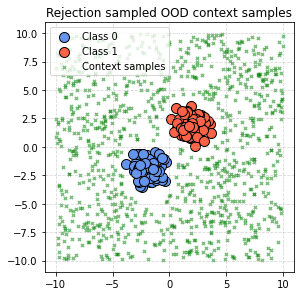

In [4]:
train_loader, _ = get_two_gaussian(batch_size=batch_size, context_type='none')

plot_train_loader(train_loader)
pretrain_context_samples = rejection_sample_ood(train_loader)
plot_reject_ood_context_loader(pretrain_context_samples)
plt.legend(loc='upper left',)
plt.title("Rejection sampled OOD context samples")
plt.show()

pretrain_context_samples = pretrain_context_samples.cuda()

### Initialize the BNN classifier
The BNN classifier is a 4-layer fully connected neural network (FNN) with 500 hidden units in each layer.

In [5]:
print(f"Initializing the BNN classifier...")
net = fnn(nin=2, nhid=500)
bnn.bayesianize_(net, inference='ffg', init_sd=0.0001, local_reparameterization=False, prior_weight_sd=1000, prior_bias_sd=1000)
net = net.cuda()
print(f"Architecture of the BNN classifier:\n{net}")

Initializing the BNN classifier...
Architecture of the BNN classifier:
FNN(
  (fc1): FFGLinear(in_features=2, out_features=500, bias=True, prior mean=0.00, prior sd=1000.00)
  (fc2): FFGLinear(in_features=500, out_features=500, bias=True, prior mean=0.00, prior sd=1000.00)
  (fc3): FFGLinear(in_features=500, out_features=500, bias=True, prior mean=0.00, prior sd=1000.00)
  (fc4): FFGLinear(in_features=500, out_features=2, bias=True, prior mean=0.00, prior sd=1000.00)
)


### Initialize the boundaryGAN
The boundaryGAN consists of a generator and a discriminator, both implemented as 4 layer fully-connected networks (FNNs).

In [6]:
print(f"Initializing the boundaryGAN...")

netG = Generator2d(1, nz, 500).cuda()
netD = Discriminator2d(1, 2, 500).cuda()

real_label = 1
fake_label = 0
criterion = nn.BCELoss()
fixed_noise = torch.FloatTensor(200, nz).normal_(0, 1).cuda()

print(f"Architecture of the boundaryGAN generator:\n{netG}")
print(f"Architecture of the boundaryGAN discriminator:\n{netD}")

Initializing the boundaryGAN...
Architecture of the boundaryGAN generator:
_2dNetG(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Tanh()
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): Tanh()
    (6): Linear(in_features=500, out_features=2, bias=True)
  )
)
Architecture of the boundaryGAN discriminator:
_2dNetD(
  (main): Sequential(
    (0): Linear(in_features=2, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [7]:
pretrain_optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
optimizerD = optim.Adam(netD.parameters(), lr=0.001, weight_decay=0.1)
optimizerG = optim.Adam(netG.parameters(), lr=0.001, weight_decay=0.1)

In [8]:
def pretrain(epoch):
    """
    Pre-train the BNN classifier using the FSVI method (Eq. (5) with OOD context samples.
    """
    net.train()
    uniform_dist = torch.Tensor(pretrain_context_samples.size(0), num_classes).fill_(1. / num_classes)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        uniform_dist = uniform_dist.cuda()

        # =========================
        # Optimize the classifier: Cross-entropy on target data + KL divergence on OOD data
        # =========================
        pretrain_optimizer.zero_grad()

        # ------ The classifier's prediction on the training data distribution ------
        output = net(data)
        acc = torch.sum(torch.max(output, 1)[1] == target).data.item() / data.size(0)
        output = F.log_softmax(output, dim=1)  # output.shape = [batch_size, num_classes]
        loss_ce = F.nll_loss(output, target)
        loss_model_kl = sum(m.kl_divergence() for m in net.modules() if hasattr(m, "kl_divergence"))

        # ------ The classifier's prediction on the OOD context samples (which we hope to be uniform) ------
        output_ood = net(pretrain_context_samples)
        output_ood = F.log_softmax(output_ood, dim=1)
        loss_ood_kl = F.kl_div(output_ood, uniform_dist, reduction='batchmean') * num_classes

        # ------ Total loss = CE + 0.1 * prior_KL + pre_beta * KL ------
        total_loss = loss_ce + 0.1 * loss_model_kl + pre_beta * loss_ood_kl
        total_loss.backward()
        pretrain_optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Pretrain Epoch: [{epoch+1}/{pretrain_epochs}]\t"
              f"CE Loss: {loss_ce.data.item():.6f}, "
              f"Model KL Loss: {loss_model_kl.data.item():.6f}, "
              f"OOD context cost: {loss_ood_kl.data.item():.6f}.")

Now we pre-train the BNN classifier using the FSVI method (Eq. (5)) with OOD context samples.

In [9]:
for epoch in range(1, pretrain_epochs + 1):
    pretrain(epoch)
    if epoch == decreasing_lr:
        pretrain_optimizer.param_groups[0]['lr'] *= drop_rate

Pretrain Epoch: [10/100]	CE Loss: 0.009718, Model KL Loss: 7792254.000000, OOD context cost: 0.014446.
Pretrain Epoch: [20/100]	CE Loss: 0.001547, Model KL Loss: 7711704.000000, OOD context cost: 0.001652.
Pretrain Epoch: [30/100]	CE Loss: 0.000567, Model KL Loss: 7631155.500000, OOD context cost: 0.000490.
Pretrain Epoch: [40/100]	CE Loss: 0.000074, Model KL Loss: 7550608.000000, OOD context cost: 0.000344.
Pretrain Epoch: [50/100]	CE Loss: 0.000017, Model KL Loss: 7470062.000000, OOD context cost: 0.000315.
Pretrain Epoch: [60/100]	CE Loss: 0.000066, Model KL Loss: 7389516.500000, OOD context cost: 0.000052.
Pretrain Epoch: [70/100]	CE Loss: 0.000097, Model KL Loss: 7373297.500000, OOD context cost: 0.000106.
Pretrain Epoch: [80/100]	CE Loss: 0.000105, Model KL Loss: 7365231.500000, OOD context cost: 0.000034.
Pretrain Epoch: [90/100]	CE Loss: 0.000087, Model KL Loss: 7357165.500000, OOD context cost: 0.000063.
Pretrain Epoch: [100/100]	CE Loss: 0.000151, Model KL Loss: 7349100.00000

The decision boundary of the pre-trained BNN classifier is shown below.

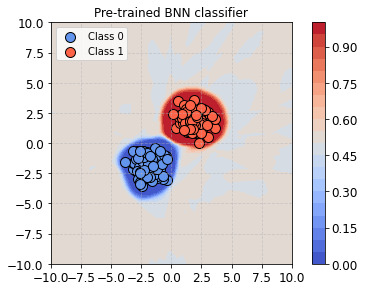

In [10]:
plot_decision_bound(net, range=(-10, 10), cbar=True)
plot_train_loader(train_loader)
plt.legend(loc='upper left')
plt.title("Pre-trained BNN classifier")
plt.show()

In [11]:
def train(epoch):
    net.eval()
    for batch_idx, (data, target) in enumerate(train_loader):

        gan_target = torch.FloatTensor(target.size()).fill_(0)
        uniform_dist = torch.Tensor(data.size(0), num_classes).fill_((1./num_classes))

        data, target = data.cuda(), target.cuda()
        gan_target, uniform_dist = gan_target.cuda(), uniform_dist.cuda()

        ###########################
        # (1) Update D network    #
        ###########################
        # train with real
        targetv = gan_target.fill_(real_label)
        optimizerD.zero_grad()
        output = netD(data)
        errD_real = criterion(output.squeeze(), targetv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise = torch.FloatTensor(data.size(0), nz).normal_(0, 1).cuda()

        noise = noise.cuda()

        fake = netG(noise)
        targetv = gan_target.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output.squeeze(), targetv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ###########################
        # (2) Update G network    #
        ###########################
        optimizerG.zero_grad()
        # Original GAN loss
        targetv = gan_target.fill_(real_label)
        output = netD(fake)
        errG = criterion(output.squeeze(), targetv)
        D_G_z2 = output.data.mean()

        # minimize the true distribution
        KL_fake_output = F.log_softmax(net(fake), dim=1)
        errG_KL = F.kl_div(KL_fake_output, uniform_dist, reduction='batchmean') * num_classes

        generator_loss = errG + beta * errG_KL
        generator_loss.backward()
        optimizerG.step()

        ###########################
        # (3) Update classifier   #
        ###########################
        # cross entropy loss + model KL divergence
        optimizer.zero_grad()
        output = F.log_softmax(net(data), dim=1)
        loss = F.nll_loss(output, target)
        loss_model_kl = sum(m.kl_divergence() for m in net.modules() if hasattr(m, "kl_divergence"))
        loss += 0.1 * loss_model_kl

        # KL divergence cost function
        noise = torch.FloatTensor(data.size(0), nz).normal_(0, 1).cuda()
        noise = noise.cuda()
        fake = netG(noise)
        KL_fake_output = F.log_softmax(net(fake), dim=1)
        KL_loss_fake = F.kl_div(KL_fake_output, uniform_dist) * num_classes
        total_loss = loss + beta * KL_loss_fake
        total_loss.backward()
        optimizer.step()

    if epoch % log_interval == 0:
        print(f"Epoch [{epoch}/{epochs}]: Discriminator Loss: {errD.data.item(): .4f}, Generator Loss: {generator_loss.data.item(): .4f}, KL Loss: {errG_KL.data.item(): .4f} "
              f"Learning Rate D: {optimizerD.param_groups[0]['lr']}, Learning Rate G: {optimizerG.param_groups[0]['lr']}")
        fake = netG(fixed_noise)

        plot_decision_bound(net, cbar=True)
        plot_train_loader(train_loader)
        plot_generative_boundary_samples(fake)

        plt.legend(loc='upper left')

        plt.title(f"Generated samples in Epoch: {epoch}")

        # plt.savefig(f'{output_results}/gan_samples_epoch_{epoch}.png', bbox_inches='tight', dpi=600)
        plt.show()

## (b) Joint-training stage
In this stage, we iteratively train the BNN classifier and the contextual generative model boundaryGAN, using our proposed joint-training algorithm (see Appendix Algorithm S1):

- The boundaryGAN is optimized using Eq. (7):
$$
\begin{gathered}
\min _{\mathrm{G}} \max _{\mathrm{D}} \underbrace{\mathbb{E}_{p(\mathbf{x})}[\log \mathrm{D}(\mathbf{x})]+\mathbb{E}_{p(\hat{\mathbf{z}})}[\log (1-\mathrm{D}(\mathrm{G}(\hat{\mathbf{z}})))]}_{(\mathrm{a})} +\underbrace{\beta \mathbb{E}_{p(\hat{\mathbf{z}})}\left[\mathbb{E}_{q(\boldsymbol{\theta})}[\operatorname{KL}(f(\mathrm{G}(\hat{\mathbf{z}}) ; \boldsymbol{\theta}) \| u)]\right]}_{(\mathrm{b})}
\end{gathered}
$$

- The BNN classifier is optimized using Eq. (8):
$$
\begin{aligned}
\max _{q(\boldsymbol{\theta}) \in Q} \overline{\mathcal{F}}(q(\boldsymbol{\theta}))= & \max _{q(\boldsymbol{\theta}) \in Q} \underbrace{\mathbb{E}_{q(\boldsymbol{\theta})}[\log p(\mathcal{T} \mid \boldsymbol{\theta})]}_{(\mathrm{c})}-\underbrace{\operatorname{KL}(q(\boldsymbol{\theta}) \| p(\boldsymbol{\theta}))}_{(\mathrm{d})} -\underbrace{\beta \mathbb{E}_{p(\hat{\mathbf{z}})}\left[\mathbb{E}_{q(\boldsymbol{\theta})}[\mathrm{KL}(f(\mathrm{G}(\hat{\mathbf{z}}) ; \boldsymbol{\theta}) \| \mathcal{U})]\right]}_{(\mathrm{e})}
\end{aligned}
$$

At each iteration, we visualize the boundary samples generated by boundaryGAN and the decision boundary of the classifier.

**Note:** We first re-initialize the optimizer for the BNN classifier as dicussed in Appendix D.6.

In [12]:
optimizer = optim.Adam(net.parameters(), lr=1e-6, weight_decay=wd)

Now, we jointly train the BNN classifier and the boundaryGAN with batch size 25 for a total of 1,000 epochs.

(The number of iterations can be adjusted to 3000 to be consistent with our paper.)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:2747: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch [100/1000]: Discriminator Loss:  0.3371, Generator Loss:  8.4915, KL Loss:  0.8376 Learning Rate D: 0.0001, Learning Rate G: 0.0001


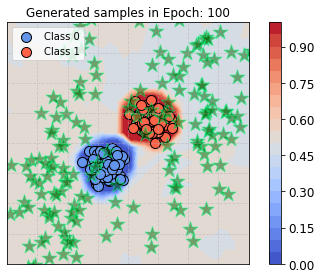

Epoch [200/1000]: Discriminator Loss:  0.3535, Generator Loss:  4.5705, KL Loss:  0.2711 Learning Rate D: 0.0001, Learning Rate G: 0.0001


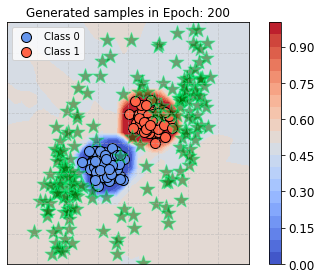

Epoch [300/1000]: Discriminator Loss:  0.5157, Generator Loss:  4.4281, KL Loss:  0.3974 Learning Rate D: 0.0001, Learning Rate G: 0.0001


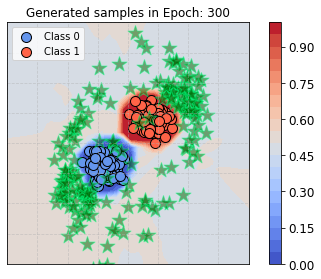

Epoch [400/1000]: Discriminator Loss:  0.5997, Generator Loss:  6.0155, KL Loss:  0.7732 Learning Rate D: 0.0001, Learning Rate G: 0.0001


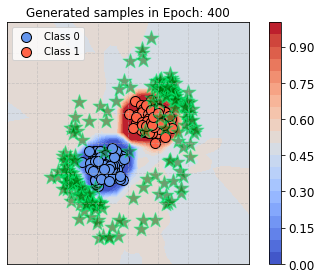

Epoch [500/1000]: Discriminator Loss:  0.4678, Generator Loss:  2.0108, KL Loss:  0.0093 Learning Rate D: 0.0001, Learning Rate G: 0.0001


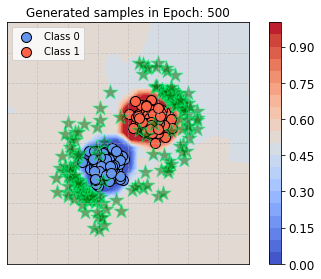

Epoch [600/1000]: Discriminator Loss:  0.5258, Generator Loss:  2.3204, KL Loss:  0.0866 Learning Rate D: 0.0001, Learning Rate G: 0.0001


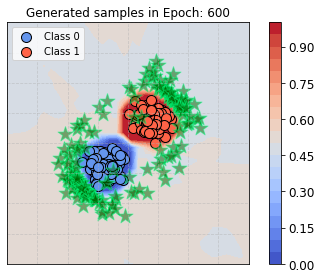

Epoch [700/1000]: Discriminator Loss:  0.5355, Generator Loss:  1.8605, KL Loss:  0.0343 Learning Rate D: 0.0001, Learning Rate G: 0.0001


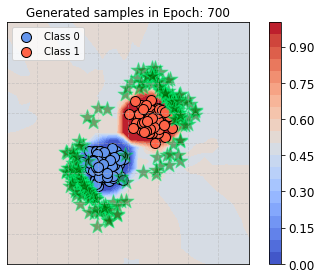

Epoch [800/1000]: Discriminator Loss:  0.4419, Generator Loss:  1.7006, KL Loss:  0.0043 Learning Rate D: 0.0001, Learning Rate G: 0.0001


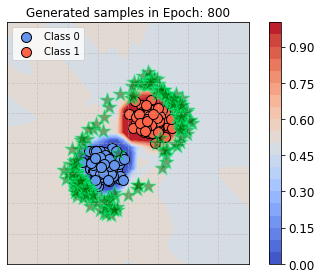

Epoch [900/1000]: Discriminator Loss:  0.6319, Generator Loss:  1.7070, KL Loss:  0.0046 Learning Rate D: 0.0001, Learning Rate G: 0.0001


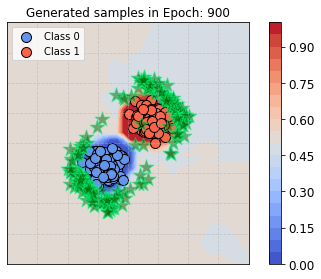

Epoch [1000/1000]: Discriminator Loss:  0.6158, Generator Loss:  2.1143, KL Loss:  0.0959 Learning Rate D: 0.0001, Learning Rate G: 0.0001


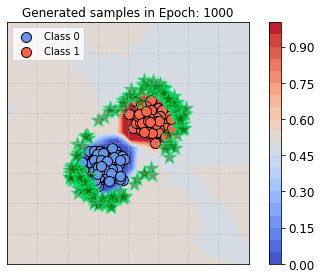

In [13]:
for epoch in range(1, epochs + 1):
    train(epoch)
    if epoch == decreasing_lr:
        optimizerG.param_groups[0]['lr'] *= drop_rate
        optimizerD.param_groups[0]['lr'] *= drop_rate
        optimizer.param_groups[0]['lr'] *= drop_rate